In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv


# <center>ST494 Final Project</center>
**April 12th, 2023**\
**Dr. Devan Becker**\
**Stefan Bukarica 190563930**\
**Rufael Musa 180571340**\
**Song Lyrics Prediction**

<div class="alert alert-info">
    
	Abstract

For this project we decided to follow the Application stream. Using the **introductory tunes in class (get it....)** and modeling techniques we learned, we decided to combine these things into a project. In this project we will attempt to predict the genre of a song based off of its lyrics. For this project we are going to be using the popular music lyrics website, Genius. Genius has a large dataset of songs containing various important information such as title, artist, genre, and most importantly lyrics. Since in our project we are curious about exploring the relationship with specifically lyrics and genre, this project will involve NLP (Natural Language Processsing) which we are both new to and thought would be a great opportunity to explore. This does mean that we will be ignoring all other features aside from lyrics. Another important note is that the dataset is ~10GB in size and much to large for us to deal with so we used a sampling approach to retrieve ~10% of the data.

Now that the problem is established, our approach was as follows:
- Tokenize and remove any unidentified characters, stop words (E.g. the, and...), etc.
- Filter the data so that only engilsh lyrics are looked at

Finally we used the following Random Forest Classifiers, Bernoulli Naive Bayes, and Gaussian Naive Bayes to predict the genre of the associated lyrics with some limited success. We explain our reasoning for choosing these models below

**ADD: Random Forests** were added becuase we wanted to explore how this model would preform in comparison

**Note**
We are aware that a Neural Network (CNN & RNN) would also be great models to predict this type of data as it can map complex relationships between the lyrics but we dont have enough processing power so we decided to avoid attempting it as it would simply take far to many hours.

In [2]:
import pandas as pd
import random
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from string import punctuation
from copy import deepcopy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import make_scorer, accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<div class="alert alert-info">
    
	Introduction / Data

We plan on using the library nltk for all our preprocessing and skelearn for our modeling. As mentioned before the data set is extremely large and our computers arent able to process them as fast. So we decided to sample 10% of the data, which is a large amount (~1 GB) but we wanted to use as much information as we could. 
Our approach to sampling the data is to generate a random integer from the range of 0-1 and after assigning some static p value. We read the file and skip the current line we are on if the value is greater than p. Intuitevly this means we should approximately get 10% of the data on average.

Dataset from: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information?resource=download\
Size: 9.07 GB



In [4]:
file_path = '/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv'
p = 0.1  
df = pd.read_csv(
         file_path,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

After reading the file we can begin filtering it for only english labeled songs then selecting an equal amount of data for each genre

### Data and Preprocessing


Our initial dataset was retrieved from Kaggle, with each record representing a song on the Genius website. The dataset is composed of the following 11 columns:

title- The name of the song

tag- genre of the song, with 5 levels; ‘misc’, ‘country’, ‘pop’, ‘rap’, ‘rb’ (RnB), and ‘rock’

artist-  The main artist of the song

year- Release year

views- Views on Genius

features- Artists featured/contributed to song

lyrics- Lyrics

id- Genius’s unique id

language_cld3- Lyrics language according to CLD3. Not reliable results are NaN

language_ft- Lyrics language according to FastText's langid. Values with low confidence (<0.5) are NaN

language- Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree"

The original dataset is a csv with a size of 9.01 GB, due to the simple ‘loading in’ of the data   
taking hours in computing time, we created a way of randomly sampling by skipping rows when reading  
our csv file such that the probability of skipping a row is a certain threshold. This allowed us to   
load in approximately 10% of our data while still randomly sampling it.   
Now that the data has been imported we can look at how we formatted a dataset to train our models on.  
As mentioned before, we do not really care about the other columns other than lyrics in this dataset however  
there are some columns which are important before we continue. First, the ‘tag’ column which is   
composed of the genres should be balanced in order for classification to be accurate for every class within   
the ‘tag’ feature. Next, the language is important since there could be many songs which are not in English   
that could result in errors with how we select to filter the words in the lyrics for training.
With these considerations,  
we began by removing punctuation, stop words, and any non alphabetical   
characters from the lyrics column.  
It's important to note that stop words are words commonly used in the English language that do not provide any benefit in a text analysis.   
  
The library we used, NLTK, has a default set of stopwords which we use: (can be used in appendix)

{‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’}


After the cleaning has been done, we apply a space in between every word to be able to vectorize these now created tokenized arrays.


In [5]:
SAMPLE = deepcopy(df)
English_Count = df['language'].value_counts()['en']
Total_Count = len(df)
print("Approximately {Percent:.2f}% of data is in english".format(Percent = English_Count/Total_Count * 100,))
SAMPLE = SAMPLE[(SAMPLE.language == "en")]
print()
SAMPLE = SAMPLE.groupby('tag').head(min(SAMPLE['tag'].value_counts()))
print(SAMPLE['tag'].value_counts())

Approximately 65.81% of data is in english

rap        8664
rock       8664
misc       8664
pop        8664
rb         8664
country    8664
Name: tag, dtype: int64


In [6]:
stop_words = set(stopwords.words('english'))
punctuation = set(punctuation)

def Clean(text):
    tokens = word_tokenize(text)
    clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.lower() not in punctuation and token.isalpha()]
    return clean_tokens

SAMPLE['lyrics'] = SAMPLE['lyrics'].apply(Clean)
data_list = []
data_list.append(SAMPLE['lyrics'])
sentences = SAMPLE['lyrics'].values
SAMPLE['lyrics'] = [' '.join(doc) for doc in sentences]
SAMPLE.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}",chorus opera steve killa cam killa cam cam kil...,1,en,en,en
1,Im Not You,rap,Clipse,2002,28645,"{Jadakiss,""Styles P"",""Roscoe P. Coldchain""}",intro pusha told lived shit ai rappin spittin ...,8,en,en,en
2,Rockin and Rollin,rap,Cam'ron,1998,6399,"{""Cam\\'ron""}",verse ay yo wonder guzzle bar see cars start d...,10,en,en,en
3,December 4th,rap,JAY-Z,2003,283714,{},produced blaze intro gloria carter shawn carte...,15,en,en,en
4,Hey AZ,rap,AZ,1997,7066,{SWV},intro az deal son world famous az show world a...,8718,en,en,en


As we can see from above the lyrics have now been shortened to only include words that are not extremely common, to give a visual depiction of how the model will create a relationship we can look at a wordcloud for each of the following genres. We can see words that are typically used in those genres of music

There is also a cool interactive visualization linked below where you can see the relationship of lyrics and genre and how they overlap in 3D\
This visualization also made us think about a Gaussian Naive Bayes model given the overlap in alot of genres. Which makes sense as\
music typically uses some similar terms/sentiments (i.e. love, hate, etc)\
Cool visual :https://chart-studio.plotly.com/~kitsamho/238/#plot


**Note**\
Some times slang and derogatory words are used in the lyrics; depending on the situation it may be useful to remove these terms but in our scenario we believe these terms are important and will help us distinguingh key differences from genre to genre. 

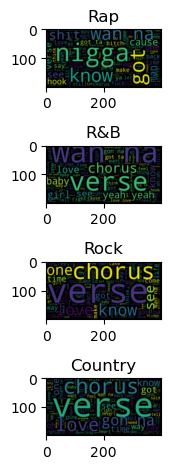

In [10]:
#R&B
rb_text = " ".join(lyrics for lyrics in SAMPLE[(SAMPLE['tag'] == "rb")]['lyrics'])
#Rock
rock_text = " ".join(lyrics for lyrics in SAMPLE[(SAMPLE['tag'] == "rock")]['lyrics'])
#country
country_text = " ".join(lyrics for lyrics in SAMPLE[(SAMPLE['tag'] == "country")]['lyrics'])
#pop
rap_text = " ".join(lyrics for lyrics in SAMPLE[(SAMPLE['tag'] == "rap")]['lyrics'])


# Create and generate a word cloud image:
rap_wordcloud = WordCloud().generate(rap_text)
rb_wordcloud = WordCloud().generate(rb_text)
rock_wordcloud = WordCloud().generate(rock_text)
country_wordcloud = WordCloud().generate(country_text)


f, axarr = plt.subplots(4,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(rap_wordcloud, interpolation='bilinear')
axarr[0].set_title("Rap")
axarr[1].imshow(rb_wordcloud, interpolation='bilinear')
axarr[1].set_title("R&B")
axarr[2].imshow(rock_wordcloud, interpolation='bilinear')
axarr[2].set_title("Rock")
axarr[3].imshow(country_wordcloud, interpolation='bilinear')
axarr[3].set_title("Country")
f.tight_layout()


<div class="alert alert-info">
    
	Methodology
    
For this section we decided to create a class which will be used to create,tune,score a model,  
we initially decided to use Gaussian & Bernouli Naive Bayes but wanted to add random forest   
just for experimentation. So all the models supported by the class are:
   - **Gaussian Naive Bayes**
   - **Bernouli Naive Bayes**
   - **Random Forest**
    
The first step in this part of the project was to create a class named classifier  
for the ease of creating multiple classification models on the training data.  
Our Classifier function has 4 properties.  

First, is the constructor which assigns  
the appropriate model to use, the X and y for training, as well as the vectorizer  
to split the words in the lyrics into an array.  

This is followed by a train-test-split,  
defaulted to an 80/20 train/test size.  

The second component is the fit method, which fits  
the appropriate model to the training data and includes an option for tuning.  
If the tuning option is selected, a grid search is used to fit the optimal parameters,  
which results in the object’s new model being fit to the parameters of the grid search.  

Thirdly, we have a predict method which predicts the genre based on our X testing data  
with a fitted model.  

Lastly is the score method, which returns an accuracy score and  
classification report of the model, the classification report is the summary of the  
precision, recall, f1-score, and support for each genre. 

This Classifier function was used to test a Gaussian Naive Bayes classifier, Bernoulli Naive Bayes classifier, and a Random Forest Classifier. 

The models were chosen since they have a good ability to  
classify multi-class predictions which is the nature of our investigation. 

In [3]:
class Classifier:
    def __init__(self, X, y, model_name):
        self.model_name = model_name
        self.model = None
        self.X = X
        self.y = y
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2)
        vectorizer = TfidfVectorizer()
        vectorizer.fit(self.x_train)
        #below are the vectorized word tokens used for training
        self.X_train = vectorizer.transform(self.x_train)
        self.X_test = vectorizer.transform(self.x_test)

    def fit(self, tune = False):

        '''
        Returns the properly fit model depending on the type of classifier we initialize

        Includes option to tune models to evaluate if they improve performance

        returns none

        '''
        if self.model_name == 'rf':
            if tune:
                param_grid = {'n_estimators': [50, 100, 150],
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}

                Grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                            param_grid = param_grid,
                            scoring='accuracy',
                            cv=5,
                            n_jobs=-1,
                           )
                self.model= Grid.fit(self.X_train, self.y_train)
            else:
                self.model = RandomForestClassifier(random_state=42).fit(self.X_train, self.y_train)
            

        if self.model_name == 'bnb':
            if tune:
                param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                              'fit_prior': [True, False]}

                grid_search = GridSearchCV(BernoulliNB(),
                    param_grid=param_grid,
                    scoring = 'accuracy',
                    n_jobs = -1,
                    cv = 5
                )

                self.model = grid_search.fit(self.X_train, self.y_train)
            else:
                self.model = BernoulliNB().fit(self.X_train, self.y_train)

        if self.model_name == 'gnb':
            if tune:
                param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

                grid_search = GridSearchCV(GaussianNB(),
                    param_grid=param_grid,
                    scoring = 'accuracy',
                    n_jobs = -1,
                    cv = 5
                )

                self.model = grid_search.fit(self.X_train, self.y_train)
            else:
                self.model = BernoulliNB().fit(self.X_train, self.y_train)
    
    def predict(self):
        '''
            Returns set of predictions for the test set
        '''
        return self.model.predict(self.X_test)
    
    def score(self):
        '''
            Returns accuracy score of the model and the classification report
        '''
        y_pred = self.predict()
        acc_score = accuracy_score(self.y_test, y_pred)
        class_report = classification_report(self.y_test, y_pred)
        return acc_score, class_report
    
        



In [12]:
X = SAMPLE['lyrics']
y = SAMPLE['tag']
BNB = Classifier(X,y,'bnb')
BNB.fit(tune = False)

accuracy_bnb = BNB.score()[0]
classification_report_bnb = BNB.score()[1]
print("The accuracy achieved by Bernoulli Naive Bayes model:", accuracy_bnb)
print('#'*60)
print("The classification report of Bernoulli Naive Bayes model: \n", classification_report_bnb)

The accuracy achieved by Bernoulli Naive Bayes model: 0.5705491968837164
############################################################
The classification report of Bernoulli Naive Bayes model: 
               precision    recall  f1-score   support

     country       0.56      0.62      0.59      1694
        misc       0.96      0.44      0.60      1685
         pop       0.32      0.44      0.37      1741
         rap       0.84      0.83      0.84      1721
          rb       0.60      0.61      0.61      1810
        rock       0.45      0.49      0.47      1746

    accuracy                           0.57     10397
   macro avg       0.63      0.57      0.58     10397
weighted avg       0.62      0.57      0.58     10397



In [13]:
GNB = Classifier(X,y,'bnb')
GNB.fit(tune = False)

accuracy_gnb = GNB.score()[0]
classification_report_gnb = GNB.score()[1]

print("The accuracy achieved by Gaussian Naive Bayes model:", accuracy_gnb)
print('#'*60)
print("The classification report of Gaussian Naive Bayes model: \n", classification_report_gnb)

The accuracy achieved by Gaussian Naive Bayes model: 0.5790131768779455
############################################################
The classification report of Gaussian Naive Bayes model: 
               precision    recall  f1-score   support

     country       0.59      0.64      0.61      1751
        misc       0.97      0.44      0.60      1719
         pop       0.34      0.42      0.37      1744
         rap       0.84      0.83      0.84      1739
          rb       0.60      0.63      0.62      1757
        rock       0.44      0.52      0.48      1687

    accuracy                           0.58     10397
   macro avg       0.63      0.58      0.59     10397
weighted avg       0.63      0.58      0.59     10397



In [34]:
RF = Classifier(X,y,'rf')
RF.fit(tune = False)

accuracy_rf = RF.score()[0]
classification_report_rf = RF.score()[1]

print("The accuracy achieved by random forest model:", accuracy_rf)
print('#'*60)
print("The classification report of random forest model: \n", classification_report_rf)

The accuracy achieved by random forest model: 0.6106569202654611
############################################################
The classification report of random forest model: 
               precision    recall  f1-score   support

     country       0.58      0.51      0.54      1772
        misc       0.83      0.79      0.81      1706
         pop       0.40      0.43      0.41      1707
         rap       0.85      0.86      0.86      1750
          rb       0.54      0.66      0.59      1709
        rock       0.48      0.42      0.45      1753

    accuracy                           0.61     10397
   macro avg       0.61      0.61      0.61     10397
weighted avg       0.61      0.61      0.61     10397



### Non-Tuned Results

Our testing of our methodology was done in various stages.  
The initial test was with a small sample of the already sampled dataset.  
We used only roughly ~52000  records from the sample to train and test the RF, GNB, and BNB classifiers.  
This resulted in a relatively low accuracy of ~61.06% for RF, ~57.1% for BNB, and ~57.9% for GNB shown in the cells above.  
Note that these were for our un-tuned models.

In [35]:
BNB_tune = Classifier(X,y,'bnb')
BNB_tune.fit(tune = True)

accuracy_bnb = BNB_tune.score()[0]
classification_report_bnb = BNB_tune.score()[1]

print("The accuracy achieved by tuned Bernoulli Naive Bayes model:", accuracy_bnb)
print('#'*60)
print("The classification report of tuned Bernoulli Naive Bayes model: \n", classification_report_bnb)

The accuracy achieved by random forest model: 0.5803597191497547
############################################################
The classification report of random forest model: 
               precision    recall  f1-score   support

     country       0.60      0.62      0.61      1728
        misc       0.96      0.45      0.61      1744
         pop       0.33      0.42      0.37      1730
         rap       0.86      0.85      0.86      1766
          rb       0.62      0.62      0.62      1723
        rock       0.42      0.52      0.46      1706

    accuracy                           0.58     10397
   macro avg       0.63      0.58      0.59     10397
weighted avg       0.63      0.58      0.59     10397



In [36]:
GNB_tune = Classifier(X,y,'bnb')
GNB_tune.fit(tune = True)

accuracy_gnb = GNB_tune.score()[0]
classification_report_gnb = GNB_tune.score()[1]

print("The accuracy achieved by tuned Gaussian Naive Bayes model:", accuracy_gnb)
print('#'*60)
print("The classification report of tuned Gaussian Naive Bayes model: \n", classification_report_gnb)

The accuracy achieved by random forest model: 0.5795902664230066
############################################################
The classification report of random forest model: 
               precision    recall  f1-score   support

     country       0.59      0.63      0.61      1764
        misc       0.96      0.48      0.64      1739
         pop       0.33      0.42      0.37      1749
         rap       0.84      0.84      0.84      1738
          rb       0.61      0.60      0.61      1706
        rock       0.43      0.50      0.46      1701

    accuracy                           0.58     10397
   macro avg       0.63      0.58      0.59     10397
weighted avg       0.63      0.58      0.59     10397



In [ ]:
RF_tune = Classifier(X,y,'rf')
RF_tune.fit(tune = True)

accuracy_rf = RF_tune.score()[0]
classification_report_rf = RF_tune.score()[1]

print("The accuracy achieved by tuned random forest model:", accuracy_rf)
print('#'*60)
print("The classification report of tuned random forest model: \n", classification_report_rf)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### Results for Tuned Models

After refitting some tuned models our accuracy slightly changes.  
This produced an accuracy of ~58.3% for RF (with smaller test set), ~58.0% for BNB and ~58.0% for GNB shown in the cells above.

We'd like to note that for RF, the results do not display but we initially ran the non tuned and tuned models on a sample of around  
6000 records. Which is where we got the 58.3% accuracymetric for the RF above. The tuned model took an extremely long amount of time to run\
when we decided to recompile the project with a larger sample of the data. You can see previous results in our github repository

### Results Overall

 
It is important to note that accuracy is not the only measure of how our model performs.  
Shown in our classification reports, our model classifies certain genres better than others  
which can be shown by a larger precision, recall, and f1-score.  

Notably, the model is very good at categorizing rap across all 3 of the  
aforementioned scores with it placing significantly higher than other genres.  
The Bayes models are more uneven than the random forest, what do we mean by this?  
The precision or recall of the ‘misc’ and ‘country’ genres are completely imbalanced. 

For example our tuned BNB model has a precision of 0.46 for country songs, but a recall of 0.86.  
On the other hand the Random Forest Model, although also inconsistent, remains more within the  
range of the f1-score. A good way to determine the variability in scores is to  
look at the f1-score and then the precision and recall.  
Since the f1-score is the harmonic mean of the two other scores, we can  
consider this like a ‘midpoint’ of sorts for what the precision or recall should be similar to.

After this investigation we changed our starting data, rather than selecting a dataset of only 6000 records,  
we enlarged it (which is the current results you are seeing) to see if our results would change.  
Typically, NLP problems require a lot of training observations  to perform text classification.  
This is why neural networks can be significantly useful as their performance often increases with large datasets.

After the change in data size, our interpretation of the imbalance in our classification reports remains the same.

We'd like to add that if you look at the word cloud there are many words that overlap in poorly classified genres such
as country, rock, and rnb, these words include chorus, verse, and others. It is important to acknowledge that these words
should be removed when reconducing this analysis because they have little to no impact on the significance of a text,
similar to how stop words are removed. This is likely why the classification is poor on those genres, because the corpus
of text contains very few genre distinct words for those genres that make it difficult for our model to identify which
genre to classify the lyrics as.

### Conclusion

We are impressed that we can classify certain genres such as rap very well, however,  
there is a lot of room for improvement in the performance of the clasification.  
As mentioned in the results, a more detailed refinement of the text corpora would  
likely result in a better text classification. 

Also, using deep learning such as an RNN could benefit the classification performance.  
Refering to Occam's razor, if a simple model suits the data well, we use it. 
It is usually a  
NLP standard to use Naive Bayes models for classification, especially multi-class.  
However, due to poorer performance an investigation into other models is necessary.

For the real world applications of a project of this nature there are many.  
One use case of these models would be a song recommendation system.  
Since most songs have lyrics attached to them, streaming services like Spotify and Apple Music  
can recommend songs with similar lyrics and genre to users who enjoy the same taste. 

Another application could be for music producers and artists. There is a column named ‘views’ which is  
usually indicative of how popular a song is due to how many times it was searched.  
So a further adaptation of this model could be to predict how popular a song will be based on lyrics.  
This way, artists and labels can strategize how to make certain artists elevate their popularity,  
although it does crush a little bit of the intuitiveness and creativeness of music generation.

Thank you for reading our project.
